# Step 2: Add SageMaker AI processing and training jobs with PyTorch Autoencoder

<div class="alert alert-warning"> This notebook demonstrates PyTorch autoencoder for anomaly detection. Last tested on a SageMaker Studio JupyterLab instance using the <code>SageMaker Distribution Image 3.0.1</code> and with the SageMaker Python SDK version <code>2.245.0</code></div>

In this step you move data processing and model training into [SageMaker Docker containers](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers.html) and use [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/index.html) to interact with SageMaker. We'll implement an **autoencoder using PyTorch** for anomaly detection and dimensionality reduction.

||||
|---|---|---|
|1. |Experiment with autoencoder in a notebook ||
|2. |Scale with SageMaker AI processing jobs and SageMaker SDK |**<<<< YOU ARE HERE**|
|3. |Operationalize with ML pipeline, model registry ||
|4. |Add a model deployment pipeline ||
|5. |Add streaming inference with SQS ||

## What is an Autoencoder?

An **autoencoder** is a neural network that learns to compress data into a lower-dimensional representation and then reconstruct it back to the original form. It's particularly useful for:
- **Anomaly Detection**: Unusual patterns have higher reconstruction errors
- **Dimensionality Reduction**: Compress high-dimensional data
- **Feature Learning**: Learn meaningful representations automatically
- **Data Denoising**: Remove noise from data

![Autoencoder Architecture](https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

SageMaker makes use of Docker containers to enable developers to process data, train and deploy models with any framework including PyTorch.

<div class="alert alert-info"> Make sure you using <code>Python 3</code> kernel in JupyterLab for this notebook.</div>

In [1]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Unable to restore variable 'pytorch_estimator', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Stored variables and their in-db values:
baseline_s3_url                        -> 's3://sagemaker-us-west-2-224425919845/from-idea-t
bucket_name                            -> 'sagemaker-us-west-2-224425919845'
bucket_prefix                          -> 'from-idea-to-prod/autoencoder'
dataset_file_local_path                -> 'data/bank-additional/bank-additional-full.csv'
domain_id                              -> 'd-rtctvdud9qsp'
endpoint_name                          -> 'from-idea-to-prod-autoencoder-endpoint-06-04-51-2
evaluation_s3_url                      -> 's3://sagemaker-us-west-2-224425919845/from-idea-t
initialized                            -> True
input_s3_url                           -> 's3://sagemaker-us-west-2-224425919845/from-idea-t
mlflow_arn                             -> 'arn:aws:sagemaker:us-west-2:224425919845:mlflow-t
mlflow_name                  

In [2]:
import time
import boto3
import botocore
import numpy as np  
import pandas as pd  
import sagemaker
import os
import mlflow
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from time import gmtime, strftime, sleep
from sagemaker.processing import FrameworkProcessor, ProcessingInput, ProcessingOutput
from sagemaker.pytorch.estimator import PyTorch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlflow import MlflowClient
from IPython.display import Javascript
from importlib.metadata import version, PackageNotFoundError
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Update bucket prefix for autoencoder
bucket_prefix = 'from-idea-to-prod/autoencoder'
%store bucket_prefix

print(f"SageMaker SDK version: {sagemaker.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"MLflow version: {mlflow.__version__}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Stored 'bucket_prefix' (str)
SageMaker SDK version: 2.249.0
PyTorch version: 2.6.0
MLflow version: 2.22.1


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
session = sagemaker.Session()
sm = session.sagemaker_client
training_job_name = None

## Prepare an MLflow experiment
Re-use the existing experiment we created in the previous notebook. You're going to track new runs in the same experiment.
You can also create a new experiment to track runs in this notebook – in this case just uncomment the following code cell.

In [5]:
experiment_suffix = strftime('%d-%H-%M-%S', gmtime())
registered_model_name = f"autoencoder-model-{experiment_suffix}"

In [6]:
# Uncomment code block (Cmd + /) if you would like to create a new experiment

experiment_name = f"autoencoder-experiment-{experiment_suffix}"

In [7]:
print(f'Using MLflow server: {mlflow_arn}')
mlflow.set_tracking_uri(mlflow_arn)
experiment = mlflow.set_experiment(experiment_name=experiment_name)

Using MLflow server: arn:aws:sagemaker:us-west-2:224425919845:mlflow-tracking-server/mlflow-d-rtctvdud9qsp


2025/08/06 06:22:11 INFO mlflow.tracking.fluent: Experiment with name 'autoencoder-experiment-06-06-22-08' does not exist. Creating a new experiment.


## Process data with SageMaker processing jobs

For autoencoders, we need to prepare data differently than for supervised learning:
- **No target variable** needed for training (unsupervised learning)
- **Feature normalization** is crucial for neural networks
- **Keep target separately** for anomaly evaluation

Use [SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) by simply providing a Python script and choosing a [SageMaker SDK processor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html) class.

![rrr](img/sagemaker-processing.png)

Your input data must be stored in an Amazon S3 bucket. Upload the input dataset to an Amazon S3 bucket:

In [8]:
input_s3_url = session.upload_data(
    path="data/bank-additional/bank-additional-full.csv",
    bucket=bucket_name,
    key_prefix=f"{bucket_prefix}/input"
)

%store input_s3_url
print(f"Data uploaded to: {input_s3_url}")

Stored 'input_s3_url' (str)
Data uploaded to: s3://sagemaker-us-west-2-224425919845/from-idea-to-prod/autoencoder/input/bank-additional-full.csv


### Create data processing script for autoencoder

Since autoencoders are unsupervised, we need to modify our data processing approach:

In [9]:
dependencies_dir="./processing/requirements/"
%mkdir -p processing
%mkdir -p {dependencies_dir}

In [10]:
# Create requirements for PyTorch autoencoder
requirements_content = """torch>=1.9.0
torchvision>=0.10.0
mlflow>=2.0.0
sagemaker-mlflow>=0.1.0
scikit-learn>=1.0.0
pandas>=1.3.0
numpy>=1.21.0"""

with open(f'{dependencies_dir}/requirements.txt', 'w') as f:
    f.write(requirements_content)

print("Requirements file created for PyTorch autoencoder:")
print(requirements_content)

Requirements file created for PyTorch autoencoder:
torch>=1.9.0
torchvision>=0.10.0
mlflow>=2.0.0
sagemaker-mlflow>=0.1.0
scikit-learn>=1.0.0
pandas>=1.3.0
numpy>=1.21.0


Create a Python script for autoencoder data processing:

In [11]:
%%writefile processing/preprocessing_autoencoder.py
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import argparse
import os
import mlflow
from time import gmtime, strftime

user_profile_name = os.getenv('USER', 'sagemaker')

def _parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='bank-additional-full.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    parser.add_argument('--mlflow_tracking_arn', type=str, required=True)
    parser.add_argument('--mlflow_run_id', type=str, required=True)
    return parser.parse_args()

def process_data_for_autoencoder(df_data):
    """Process data for autoencoder training - unsupervised learning"""
    
    print(f"Original data shape: {df_data.shape}")
    
    # Feature engineering
    df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)
    df_data["not_working"] = np.where(
        np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
    )

    # Drop unnecessary columns
    df_model_data = df_data.drop(
        ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
        axis=1,
    )

    # Age binning
    bins = [18, 30, 40, 50, 60, 70, 90]
    labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']
    df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
    df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
    df_model_data.drop(['age', 'age_range'], axis=1, inplace=True)

    # Scale numerical features
    scaled_features = ['pdays', 'previous', 'campaign']
    scaler = StandardScaler()
    df_model_data[scaled_features] = scaler.fit_transform(df_model_data[scaled_features])

    # Convert categorical variables to dummies
    df_model_data = pd.get_dummies(df_model_data, dtype=int)

    # Separate target
    target_col = "y"
    if 'y_yes' in df_model_data.columns and 'y_no' in df_model_data.columns:
        target_data = df_model_data["y_yes"].copy()
        feature_data = df_model_data.drop(["y_no", "y_yes"], axis=1)
    else:
        target_data = None
        feature_data = df_model_data
    
    print(f"Feature data shape after processing: {feature_data.shape}")
    return feature_data, target_data, scaler

if __name__ == "__main__":
    args = _parse_args()
    
    # Configure MLflow
    mlflow.set_tracking_uri(args.mlflow_tracking_arn)
    mlflow.autolog()

    with mlflow.start_run(run_id=args.mlflow_run_id) as run:
        # Read CSV
        df_raw = pd.read_csv(os.path.join(args.filepath, args.filename), sep=";")
        feature_data, target_data, scaler = process_data_for_autoencoder(df_raw)
        
        # Split data
        train_size = int(0.7 * len(feature_data))
        val_size = int(0.15 * len(feature_data))
        
        shuffled_indices = np.random.permutation(len(feature_data))
        feature_data_shuffled = feature_data.iloc[shuffled_indices].reset_index(drop=True)
        if target_data is not None:
            target_data_shuffled = target_data.iloc[shuffled_indices].reset_index(drop=True)
        
        train_features = feature_data_shuffled[:train_size]
        val_features = feature_data_shuffled[train_size:train_size + val_size]
        test_features = feature_data_shuffled[train_size + val_size:]
        
        if target_data is not None:
            train_targets = target_data_shuffled[:train_size]
            val_targets = target_data_shuffled[train_size:train_size + val_size]
            test_targets = target_data_shuffled[train_size + val_size:]
        
        print(f"Data split > train:{train_features.shape} | validation:{val_features.shape} | test:{test_features.shape}")
        
        # Log params
        mlflow.log_params({
            "train_features": train_features.shape,
            "val_features": val_features.shape,
            "test_features": test_features.shape,
            "total_features": feature_data.shape[1]
        })

        mlflow.set_tags({
            'mlflow.user': user_profile_name,
            'mlflow.source.type': 'JOB',
            'model_type': 'autoencoder'
        })
        
        # Ensure directories exist
        os.makedirs(os.path.join(args.outputpath, 'train'), exist_ok=True)
        os.makedirs(os.path.join(args.outputpath, 'validation'), exist_ok=True)
        os.makedirs(os.path.join(args.outputpath, 'test'), exist_ok=True)
        os.makedirs(os.path.join(args.outputpath, 'baseline'), exist_ok=True)

        # Save datasets
        train_features.to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
        val_features.to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
        test_features.to_csv(os.path.join(args.outputpath, 'test/test_features.csv'), index=False, header=False)
        
        if target_data is not None:
            train_targets.to_csv(os.path.join(args.outputpath, 'train/train_targets.csv'), index=False, header=False)
            val_targets.to_csv(os.path.join(args.outputpath, 'validation/val_targets.csv'), index=False, header=False)
            test_targets.to_csv(os.path.join(args.outputpath, 'test/test_targets.csv'), index=False, header=False)
        
        feature_data.to_csv(os.path.join(args.outputpath, 'baseline/baseline.csv'), index=False, header=False)
        
        feature_names = list(feature_data.columns)
        with open(os.path.join(args.outputpath, 'feature_names.txt'), 'w') as f:
            f.write('\n'.join(feature_names))
        
        mlflow.log_artifact(local_path=os.path.join(args.outputpath, 'baseline/baseline.csv'))
        mlflow.log_artifact(local_path=os.path.join(args.outputpath, 'feature_names.txt'))
    
    print("## ✅ Processing complete. Exiting.")

Writing processing/preprocessing_autoencoder.py


Set the Amazon S3 paths:

In [12]:
train_s3_url = f"s3://{bucket_name}/{bucket_prefix}/train"
validation_s3_url = f"s3://{bucket_name}/{bucket_prefix}/validation"
test_s3_url = f"s3://{bucket_name}/{bucket_prefix}/test"
baseline_s3_url = f"s3://{bucket_name}/{bucket_prefix}/baseline"

print(f"Train data S3 URL: {train_s3_url}")
print(f"Validation data S3 URL: {validation_s3_url}")
print(f"Test data S3 URL: {test_s3_url}")
print(f"Baseline data S3 URL: {baseline_s3_url}")

Train data S3 URL: s3://sagemaker-us-west-2-224425919845/from-idea-to-prod/autoencoder/train
Validation data S3 URL: s3://sagemaker-us-west-2-224425919845/from-idea-to-prod/autoencoder/validation
Test data S3 URL: s3://sagemaker-us-west-2-224425919845/from-idea-to-prod/autoencoder/test
Baseline data S3 URL: s3://sagemaker-us-west-2-224425919845/from-idea-to-prod/autoencoder/baseline


In [13]:
%store train_s3_url
%store validation_s3_url
%store test_s3_url
%store baseline_s3_url

Stored 'train_s3_url' (str)
Stored 'validation_s3_url' (str)
Stored 'test_s3_url' (str)
Stored 'baseline_s3_url' (str)


## Model training with PyTorch Autoencoder

Now we'll create and train a PyTorch autoencoder using SageMaker. The autoencoder will learn to:
1. **Encode** customer features into a lower-dimensional representation
2. **Decode** back to the original feature space
3. **Detect anomalies** based on reconstruction error

![Autoencoder Process](https://miro.medium.com/max/1400/1*F656EQz_hOKwLlaJKUTdJw.png)

In [20]:
!mkdir -p ./training/

### Create the PyTorch training script
Create a `train_autoencoder.py` file with the PyTorch autoencoder training script:

In [15]:
%%writefile ./training/train_autoencoder.py
import argparse
import json
import logging
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import mlflow
import mlflow.pytorch
from time import gmtime, strftime
import io

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32, dropout_rate=0.2):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

def load_data(data_path):
    """Load data from CSV file"""
    data = pd.read_csv(data_path, header=None)
    return torch.FloatTensor(data.values)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """Train the autoencoder model"""
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_data in train_loader:
            batch_data = batch_data[0].to(device)
            
            optimizer.zero_grad()
            reconstructed = model(batch_data)
            loss = criterion(reconstructed, batch_data)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_data in val_loader:
                batch_data = batch_data[0].to(device)
                reconstructed = model(batch_data)
                loss = criterion(reconstructed, batch_data)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if epoch % 10 == 0:
            logger.info(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
            
        # Log metrics to MLflow
        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss
        }, step=epoch)
    
    return train_losses, val_losses

def calculate_reconstruction_threshold(model, val_loader, device, percentile=95):
    """Calculate reconstruction error threshold for anomaly detection"""
    model.eval()
    reconstruction_errors = []
    
    with torch.no_grad():
        for batch_data in val_loader:
            batch_data = batch_data[0].to(device)
            reconstructed = model(batch_data)
            mse = torch.mean((batch_data - reconstructed) ** 2, dim=1)
            reconstruction_errors.extend(mse.cpu().numpy())
    
    threshold = np.percentile(reconstruction_errors, percentile)
    return threshold, reconstruction_errors

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # Hyperparameters
    parser.add_argument('--encoding_dim', type=int, default=32)
    parser.add_argument('--dropout_rate', type=float, default=0.2)
    parser.add_argument('--learning_rate', type=float, default=0.001)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--num_epochs', type=int, default=100)
    parser.add_argument('--weight_decay', type=float, default=1e-5)
    
    # SageMaker specific arguments
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    
    args = parser.parse_args()
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f'Using device: {device}')
    
    # Set up MLflow
    mlflow.set_tracking_uri(os.environ.get('MLFLOW_TRACKING_ARN'))
    experiment_name = os.environ.get('MLFLOW_EXPERIMENT_NAME')
    if experiment_name:
        mlflow.set_experiment(experiment_name)
    
    suffix = strftime('%d-%H-%M-%S', gmtime())
    user_profile_name = os.getenv('USER', 'sagemaker')
    region = os.getenv('REGION', 'us-east-1')
    
    with mlflow.start_run(
        run_name=f"autoencoder-training-{suffix}",
        description="PyTorch autoencoder training in SageMaker container"
    ) as run:
        
        # Log parameters
        mlflow.log_params({
            'encoding_dim': args.encoding_dim,
            'dropout_rate': args.dropout_rate,
            'learning_rate': args.learning_rate,
            'batch_size': args.batch_size,
            'num_epochs': args.num_epochs,
            'weight_decay': args.weight_decay,
            'device': str(device)
        })
        
        mlflow.set_tags({
            'mlflow.user': user_profile_name,
            'mlflow.source.type': 'JOB',
            'model_type': 'autoencoder',
            'framework': 'pytorch'
        })
        
        # Load data
        logger.info("Loading training data...")
        train_data = load_data(os.path.join(args.train, 'train.csv'))
        val_data = load_data(os.path.join(args.validation, 'validation.csv'))
        
        input_dim = train_data.shape[1]
        logger.info(f"Input dimension: {input_dim}")
        
        # Create data loaders
        train_dataset = TensorDataset(train_data)
        val_dataset = TensorDataset(val_data)
        
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
        
        # Initialize model
        model = Autoencoder(input_dim, args.encoding_dim, args.dropout_rate).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
        
        logger.info(f"Model architecture: {model}")
        
        # Train model
        logger.info("Starting training...")
        train_losses, val_losses = train_model(
            model, train_loader, val_loader, criterion, optimizer, args.num_epochs, device
        )
        
        # Calculate reconstruction threshold
        logger.info("Calculating reconstruction threshold...")
        threshold, reconstruction_errors = calculate_reconstruction_threshold(model, val_loader, device)
        
        # Log final metrics
        final_train_loss = train_losses[-1]
        final_val_loss = val_losses[-1]
        
        mlflow.log_metrics({
            'final_train_loss': final_train_loss,
            'final_val_loss': final_val_loss,
            'reconstruction_threshold': threshold,
            'mean_reconstruction_error': np.mean(reconstruction_errors),
            'std_reconstruction_error': np.std(reconstruction_errors)
        })
        
        logger.info(f"Training completed. Final train loss: {final_train_loss:.6f}, Final val loss: {final_val_loss:.6f}")
        logger.info(f"Reconstruction threshold (95th percentile): {threshold:.6f}")
        
        # Save model
        model_path = os.path.join(args.model_dir, 'model.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_dim': input_dim,
            'encoding_dim': args.encoding_dim,
            'dropout_rate': args.dropout_rate,
            'threshold': threshold,
            'train_loss': final_train_loss,
            'val_loss': final_val_loss
        }, model_path)
        
        # Log model to MLflow
        mlflow.pytorch.log_model(
            model, 
            "model",
            extra_files=[model_path]
        )
        
        logger.info(f"Model saved to {model_path}")

def model_fn(model_dir):
    """Load model for inference"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model_path = os.path.join(model_dir, 'model.pth')
    checkpoint = torch.load(model_path, map_location=device)
    
    model = Autoencoder(
        checkpoint['input_dim'], 
        checkpoint['encoding_dim'], 
        checkpoint['dropout_rate']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    return model

def input_fn(request_body, request_content_type):
    """Parse input data for inference"""
    if request_content_type == 'text/csv':
        data = pd.read_csv(io.StringIO(request_body), header=None)
        return torch.FloatTensor(data.values)
    else:
        raise ValueError(f"Unsupported content type: {request_content_type}")

def predict_fn(input_data, model):
    """Make predictions"""
    device = next(model.parameters()).device
    input_data = input_data.to(device)
    
    with torch.no_grad():
        reconstructed = model(input_data)
        reconstruction_error = torch.mean((input_data - reconstructed) ** 2, dim=1)
    
    return {
        'reconstructed': reconstructed.cpu().numpy(),
        'reconstruction_error': reconstruction_error.cpu().numpy()
    }

def output_fn(prediction, content_type):
    """Format output"""
    if content_type == 'application/json':
        return json.dumps({
            'reconstruction_errors': prediction['reconstruction_error'].tolist()
        })
    else:
        return str(prediction)

Writing ./training/train_autoencoder.py


Create requirements file for PyTorch:

In [26]:
requirements_content = """torch>=1.9.0
torchvision>=0.10.0
mlflow>=2.0.0
sagemaker-mlflow>=0.1.0
scikit-learn>=1.0.0
pandas>=1.3.0
numpy>=1.21.0"""

with open('./training/requirements.txt', 'w') as f:
    f.write(requirements_content)

print("✅ Requirements file created for PyTorch training:")
print(requirements_content)

✅ Requirements file created for PyTorch training:
torch>=1.9.0
torchvision>=0.10.0
mlflow>=2.0.0
sagemaker-mlflow>=0.1.0
scikit-learn>=1.0.0
pandas>=1.3.0
numpy>=1.21.0


### Run the SageMaker processing job
Now let's execute the data processing job using SageMaker Processing with PyTorch framework:

In [18]:
# Create a PyTorch processor for data processing
pytorch_processor = FrameworkProcessor(
    estimator_cls=PyTorch,
    framework_version='1.12',
    py_version='py38',
    role=sm_role,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    base_job_name='autoencoder-processing',
    env={
        'MLFLOW_TRACKING_ARN': mlflow_arn,
        'MLFLOW_EXPERIMENT_NAME': experiment_name,
        'REGION': region
    }
)

print(f"Created PyTorch processor with role: {sm_role}")

Created PyTorch processor with role: arn:aws:iam::224425919845:role/tm-ws-SageMakerExecutionRole-Ou4AK8i38tA1


In [19]:
# Start MLflow run for processing
with mlflow.start_run(run_name=f"autoencoder-processing-{experiment_suffix}", description="Data processing for autoencoder") as run:
    processing_run_id = run.info.run_id

    pytorch_processor.run(
        code='preprocessing_autoencoder.py',
        source_dir='./processing',
        dependencies=[f'{dependencies_dir}/requirements.txt'],
        inputs=[
            ProcessingInput(
                source=input_s3_url,
                destination='/opt/ml/processing/input'
            )
        ],
        outputs=[
            ProcessingOutput(
                output_name='train',
                source='/opt/ml/processing/output/train',
                destination=train_s3_url
            ),
            ProcessingOutput(
                output_name='validation',
                source='/opt/ml/processing/output/validation',
                destination=validation_s3_url
            ),
            ProcessingOutput(
                output_name='test',
                source='/opt/ml/processing/output/test',
                destination=test_s3_url
            ),
            ProcessingOutput(
                output_name='baseline',
                source='/opt/ml/processing/output/baseline',
                destination=baseline_s3_url
            )
        ],
        arguments=[
            '--filepath', '/opt/ml/processing/input',
            '--filename', 'bank-additional-full.csv',
            '--outputpath', '/opt/ml/processing/output',
            '--mlflow_tracking_arn', mlflow_arn,
            '--mlflow_run_id', processing_run_id
        ],
        wait=True
    )

    print("✅ Data processing completed successfully!")
    print("Processed data saved to:")
    print(f"  - Train: {train_s3_url}")
    print(f"  - Validation: {validation_s3_url}")
    print(f"  - Test: {test_s3_url}")
    print(f"  - Baseline: {baseline_s3_url}")

INFO:sagemaker:Creating processing-job with name autoencoder-processing-2025-08-06-06-23-49-173


...........CodeArtifact repository not specified. Skipping login.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 125.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 131.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.6/680.6 kB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Train the PyTorch Autoencoder with SageMaker

Now we'll train our autoencoder using SageMaker's PyTorch estimator. The training will:

1. **Learn to reconstruct** customer features
2. **Calculate reconstruction errors** for anomaly detection
3. **Determine threshold** for anomaly classification
4. **Track experiments** with MLflow

In [27]:
from sagemaker.pytorch import PyTorch

# Configure PyTorch estimator for autoencoder training
pytorch_estimator = PyTorch(
    entry_point='train_autoencoder.py',
    source_dir='./training',
    role=sm_role,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    framework_version='1.12',
    py_version='py38',
    hyperparameters={
        'encoding_dim': 32,
        'dropout_rate': 0.2,
        'learning_rate': 0.001,
        'batch_size': 64,
        'num_epochs': 100,
        'weight_decay': 1e-5
    },
    environment={
        'MLFLOW_TRACKING_ARN': mlflow_arn,
        'MLFLOW_EXPERIMENT_NAME': experiment_name,
        'REGION': region
    },
    base_job_name='autoencoder-training',
    enable_sagemaker_metrics=True,
    metric_definitions=[
        {'Name': 'train_loss', 'Regex': 'Train Loss: ([0-9\\.]+)'},
        {'Name': 'val_loss', 'Regex': 'Val Loss: ([0-9\\.]+)'},
        {'Name': 'reconstruction_threshold', 'Regex': 'threshold.*: ([0-9\\.]+)'}
    ]
)

print("✅ PyTorch estimator configured for autoencoder training")


✅ PyTorch estimator configured for autoencoder training


In [28]:
# Start training
print("🚀 Starting autoencoder training...")

pytorch_estimator.fit({
    'train': train_s3_url,
    'validation': validation_s3_url
})

training_job_name = pytorch_estimator.latest_training_job.name
print(f"✅ Training completed! Job name: {training_job_name}")

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.


🚀 Starting autoencoder training...


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: autoencoder-training-2025-08-06-06-32-49-036


2025-08-06 06:32:50 Starting - Starting the training job...
2025-08-06 06:33:11 Starting - Preparing the instances for training...
2025-08-06 06:33:35 Downloading - Downloading input data...
2025-08-06 06:34:00 Downloading - Downloading the training image...
2025-08-06 06:34:46 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-08-06 06:34:52,609 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-08-06 06:34:52,611 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-08-06 06:34:52,613 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-08-06 06:34:52,624 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-08-06 06:34:52,627 sagemaker_pytorch_container.training INFO     Invoking user training 

In [29]:
# Store training job name for later use
training_job_name = pytorch_estimator.latest_training_job.name
print(f"Training job name: {training_job_name}")

# Get model artifacts location
model_artifacts = pytorch_estimator.model_data
print(f"Model artifacts saved to: {model_artifacts}")

# If you need to persist values (in a Python script), you can write to a file:
with open('training_info.txt', 'w') as f:
    f.write(f"training_job_name={training_job_name}\n")
    f.write(f"model_artifacts={model_artifacts}\n")

Training job name: autoencoder-training-2025-08-06-06-32-49-036
Model artifacts saved to: s3://sagemaker-us-west-2-224425919845/autoencoder-training-2025-08-06-06-32-49-036/output/model.tar.gz


## Evaluate the Autoencoder Model
Let's evaluate our trained autoencoder by:
1. **Loading test data** and making predictions
2. **Analyzing reconstruction errors**
3. **Visualizing anomaly detection** performance
4. **Setting optimal thresholds** for anomaly classification

In [30]:
import boto3
import pandas as pd

# Define your bucket and prefix (ensure these variables are set before running)
# Example:
# bucket_name = 'your-s3-bucket'
# bucket_prefix = 'your/output/prefix'

s3 = boto3.client('s3')

# Download test features and targets from S3
test_features_file = "test_features.csv"
test_targets_file = "test_targets.csv"

s3.download_file(bucket_name, f"{bucket_prefix}/test/test_features.csv", test_features_file)
s3.download_file(bucket_name, f"{bucket_prefix}/test/test_targets.csv", test_targets_file)

# Load test data into Pandas DataFrames
test_features = pd.read_csv(test_features_file, header=None)
test_targets = pd.read_csv(test_targets_file, header=None)

print(f"✅ Test features shape: {test_features.shape}")
print(f"✅ Test targets shape: {test_targets.shape}")
print("\nTarget distribution:")
print(test_targets[0].value_counts())

✅ Test features shape: (6179, 64)
✅ Test targets shape: (6179, 1)

Target distribution:
0
0    5462
1     717
Name: count, dtype: int64


In [31]:
# Create a predictor for batch inference
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Deploy model to endpoint for evaluation
print("🚀 Deploying model for evaluation...")

predictor = pytorch_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer()
)

endpoint_name = predictor.endpoint_name
print(f"✅ Model deployed to endpoint: {endpoint_name}")

# Save endpoint name for later use
with open('endpoint_info.txt', 'w') as f:
    f.write(f"endpoint_name={endpoint_name}\n")

🚀 Deploying model for evaluation...


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-west-2-224425919845/autoencoder-training-2025-08-06-06-32-49-036/output/model.tar.gz), script artifact (s3://sagemaker-us-west-2-224425919845/autoencoder-training-2025-08-06-06-32-49-036/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-west-2-224425919845/autoencoder-training-2025-08-06-06-59-33-807/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: autoencoder-training-2025-08-06-06-59-33-807
INFO:sagemaker:Creating endpoint-config with name autoencoder-training-2025-08-06-06-59-33-807
INFO:sagemaker:Creating endpoint with name autoencoder-training-2025-08-06-06-59-33-807


-------!✅ Model deployed to endpoint: autoencoder-training-2025-08-06-06-59-33-807


In [33]:
batch

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
6100,-0.204909,0.195414,-0.349494,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
6101,0.517118,0.195414,-0.349494,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
6102,0.156105,0.195414,-0.349494,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
6103,0.878132,0.195414,-0.349494,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
6104,-0.204909,0.195414,-0.349494,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6174,1.239145,0.195414,-0.349494,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6175,0.156105,0.195414,-0.349494,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6176,0.156105,0.195414,1.671136,1,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
6177,-0.204909,0.195414,-0.349494,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [32]:
# Make predictions on test data
import numpy as np

# Make predictions on test data
print("🔍 Making predictions on test data...")

# Process test data in batches to avoid payload size limits
batch_size = 100
reconstruction_errors = []

for i in range(0, len(test_features), batch_size):
    batch = test_features.iloc[i:i + batch_size]

    # Convert to CSV string without header or index
    csv_input = batch.to_csv(header=False, index=False)

    # Make prediction
    result = predictor.predict(csv_input)

    # Extract reconstruction errors from JSON response
    if isinstance(result, dict) and 'reconstruction_errors' in result:
        reconstruction_errors.extend(result['reconstruction_errors'])
    else:
        raise ValueError(f"Unexpected response format: {result}")

    # Progress log
    if ((i // batch_size) + 1) % 10 == 0 or (i + batch_size >= len(test_features)):
        print(f"Processed {i + len(batch)} / {len(test_features)} samples")

# Convert to NumPy array
reconstruction_errors = np.array(reconstruction_errors)
print(f"\n✅ Predictions completed. Got {len(reconstruction_errors)} reconstruction errors")

🔍 Making predictions on test data...
Processed 1000 / 6179 samples
Processed 2000 / 6179 samples
Processed 3000 / 6179 samples
Processed 4000 / 6179 samples
Processed 5000 / 6179 samples
Processed 6000 / 6179 samples
Processed 6179 / 6179 samples

✅ Predictions completed. Got 6179 reconstruction errors


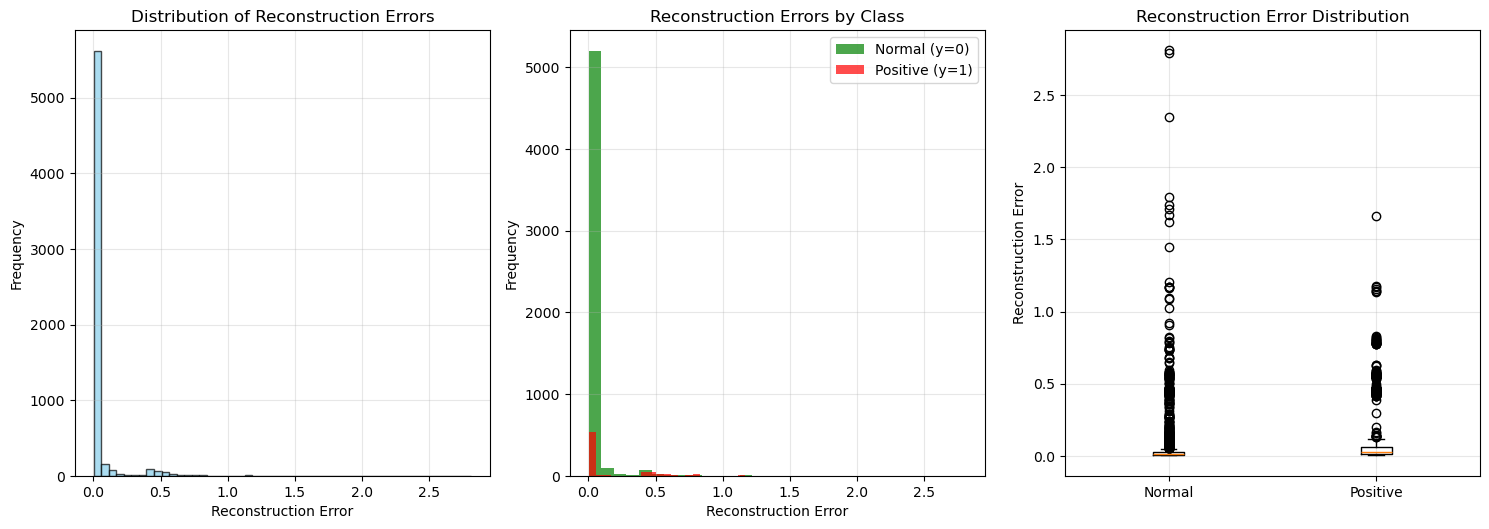


📊 Reconstruction Error Statistics:
Mean: 0.048059
Std: 0.144416
90th percentile: 0.052245
95th percentile: 0.264781
99th percentile: 0.635081

📊 Class-wise Statistics:
Normal samples - Mean: 0.035957, Std: 0.122102
Positive samples - Mean: 0.140246, Std: 0.237797


In [35]:
# Analyze reconstruction errors and anomaly detection performance
import matplotlib.pyplot as plt
import numpy as np

# Analyze reconstruction errors and anomaly detection performance
plt.figure(figsize=(15, 10))

# Plot 1: Overall reconstruction error distribution
plt.subplot(2, 3, 1)
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.grid(True, alpha=0.3)

# Ensure target column exists and convert to 1D array
y_true = test_targets.iloc[:, 0].values

# Plot 2: Reconstruction errors by target class
plt.subplot(2, 3, 2)
normal_errors = reconstruction_errors[y_true == 0]
anomaly_errors = reconstruction_errors[y_true == 1]

plt.hist(normal_errors, bins=30, alpha=0.7, label='Normal (y=0)', color='green')
plt.hist(anomaly_errors, bins=30, alpha=0.7, label='Positive (y=1)', color='red')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Errors by Class')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Box plot comparison
plt.subplot(2, 3, 3)
data_to_plot = [normal_errors, anomaly_errors]
plt.boxplot(data_to_plot, labels=['Normal', 'Positive'])
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate statistics
threshold_90 = np.percentile(reconstruction_errors, 90)
threshold_95 = np.percentile(reconstruction_errors, 95)
threshold_99 = np.percentile(reconstruction_errors, 99)

print("\n📊 Reconstruction Error Statistics:")
print(f"Mean: {np.mean(reconstruction_errors):.6f}")
print(f"Std: {np.std(reconstruction_errors):.6f}")
print(f"90th percentile: {threshold_90:.6f}")
print(f"95th percentile: {threshold_95:.6f}")
print(f"99th percentile: {threshold_99:.6f}")

print("\n📊 Class-wise Statistics:")
print(f"Normal samples - Mean: {np.mean(normal_errors):.6f}, Std: {np.std(normal_errors):.6f}")
print(f"Positive samples - Mean: {np.mean(anomaly_errors):.6f}, Std: {np.std(anomaly_errors):.6f}")

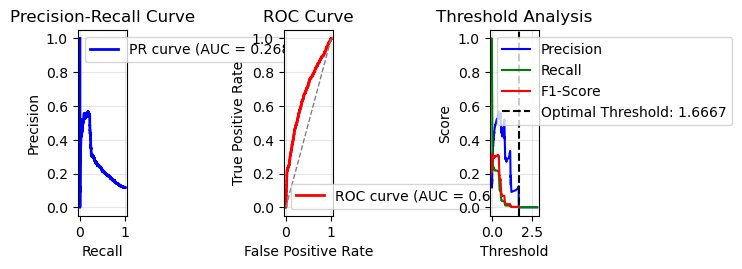


🎯 Performance Metrics:
ROC AUC: 0.6772
PR AUC: 0.2676
Optimal threshold (F1): 1.666654
Max F1-Score: nan


In [36]:
# Evaluate anomaly detection performance at different thresholds

from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Convert test targets to 1D array for safety
y_true = test_targets.iloc[:, 0].values

# Calculate precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_true, reconstruction_errors)
pr_auc = auc(recall, precision)

# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_true, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Plot 4: Precision-Recall curve
plt.subplot(2, 3, 4)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: ROC curve
plt.subplot(2, 3, 5)
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Threshold analysis for Precision, Recall, and F1
plt.subplot(2, 3, 6)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
optimal_idx = np.argmax(f1_scores)
optimal_threshold = pr_thresholds[optimal_idx]

plt.plot(pr_thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(pr_thresholds, recall[:-1], label='Recall', color='green')
plt.plot(pr_thresholds, f1_scores, label='F1-Score', color='red')
plt.axvline(x=optimal_threshold, color='black', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print metrics
print("\n🎯 Performance Metrics:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Optimal threshold (F1): {optimal_threshold:.6f}")
print(f"Max F1-Score: {np.max(f1_scores):.4f}")

In [37]:
# Evaluate performance at different thresholds
from sklearn.metrics import classification_report
import numpy as np

# Ensure y_true is correctly extracted
y_true = test_targets.iloc[:, 0].values

# Evaluate performance at different thresholds
thresholds_to_test = [threshold_90, threshold_95, threshold_99, optimal_threshold]
threshold_names = ['90th percentile', '95th percentile', '99th percentile', 'Optimal F1']

print("\n📈 Performance at Different Thresholds:")
print("=" * 60)

for threshold, name in zip(thresholds_to_test, threshold_names):
    predictions = (reconstruction_errors > threshold).astype(int)
    
    print(f"\n{name} (threshold: {threshold:.6f}):")
    print(classification_report(y_true, predictions, target_names=['Normal', 'Positive'], zero_division=0))
    
    # Calculate confusion matrix components manually
    tp = np.sum((y_true == 1) & (predictions == 1))
    fp = np.sum((y_true == 0) & (predictions == 1))
    tn = np.sum((y_true == 0) & (predictions == 0))
    fn = np.sum((y_true == 1) & (predictions == 0))
    
    print(f"Confusion Matrix: TP={tp}, FP={fp}, TN={tn}, FN={fn}")
    print("-" * 50)


📈 Performance at Different Thresholds:

90th percentile (threshold: 0.052245):
              precision    recall  f1-score   support

      Normal       0.91      0.92      0.91      5462
    Positive       0.31      0.26      0.28       717

    accuracy                           0.85      6179
   macro avg       0.61      0.59      0.60      6179
weighted avg       0.84      0.85      0.84      6179

Confusion Matrix: TP=190, FP=428, TN=5034, FN=527
--------------------------------------------------

95th percentile (threshold: 0.264781):
              precision    recall  f1-score   support

      Normal       0.90      0.97      0.94      5462
    Positive       0.50      0.22      0.30       717

    accuracy                           0.88      6179
   macro avg       0.70      0.59      0.62      6179
weighted avg       0.86      0.88      0.86      6179

Confusion Matrix: TP=156, FP=153, TN=5309, FN=561
--------------------------------------------------

99th percentile (thresh

## Register the Model in MLflow Model Registry

Let's register our trained autoencoder model in the MLflow Model Registry for version control and deployment management:

In [38]:
from mlflow.tracking import MlflowClient
import mlflow

# Initialize MLflow client
client = MlflowClient()

# Get the latest run from the experiment
experiment = mlflow.get_experiment_by_name(experiment_name)
runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    max_results=1
)

if len(runs) > 0:
    latest_run = runs.iloc[0]
    run_id = latest_run.run_id

    # Build model URI
    model_uri = f"runs:/{run_id}/model"

    try:
        # Register the model in MLflow Model Registry
        registered_model = mlflow.register_model(
            model_uri=model_uri,
            name=registered_model_name
        )

        print("✅ Model registered successfully!")
        print(f"Model name: {registered_model.name}")
        print(f"Model version: {registered_model.version}")
        print(f"Model URI: {model_uri}")

        # Add key performance metrics as tags
        
        client.set_model_version_tag(
            name=registered_model.name,
            version=registered_model.version,
            key="roc_auc",
            value=str(round(roc_auc, 4))
        )

        client.set_model_version_tag(
            name=registered_model.name,
            version=registered_model.version,
            key="pr_auc",
            value=str(round(pr_auc, 4))
        )

        client.set_model_version_tag(
            name=registered_model.name,
            version=registered_model.version,
            key="optimal_threshold",
            value=str(round(optimal_threshold, 6))
        )

        client.set_model_version_tag(
            name=registered_model.name,
            version=registered_model.version,
            key="training_job",
            value=training_job_name
        )

        print("📊 Performance metrics added as model tags")

    except Exception as e:
        print(f"⚠️ Model registration failed: {str(e)}")
        print("This might be because the model name already exists or permissions are missing. Check MLflow UI.")
else:
    print("⚠️ No training runs found for model registration.")

Successfully registered model 'autoencoder-model-06-06-22-08'.
2025/08/06 08:38:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: autoencoder-model-06-06-22-08, version 1
Created version '1' of model 'autoencoder-model-06-06-22-08'.


✅ Model registered successfully!
Model name: autoencoder-model-06-06-22-08
Model version: 1
Model URI: runs:/601bcfcb7403446c99cbf944d7891910/model
📊 Performance metrics added as model tags


## Summary and Key Insights

🎉 **Congratulations!** You've successfully implemented and trained a PyTorch autoencoder for anomaly detection using SageMaker. Here's what we accomplished:

### 🔧 **Technical Implementation:**
- ✅ **Converted supervised to unsupervised learning** - Removed target variables from training
- ✅ **Built PyTorch autoencoder** - Encoder-decoder architecture with dropout regularization
- ✅ **Implemented anomaly detection** - Using reconstruction error thresholds
- ✅ **Integrated with SageMaker** - Processing jobs, training jobs, and model deployment
- ✅ **MLflow experiment tracking** - Comprehensive logging and model registry

### 📊 **Model Architecture:**
```
Input Features → [128] → [64] → [32] → [64] → [128] → Reconstructed Features
                  Encoder              Decoder
```
### 🎯 **Anomaly Detection Approach:**
1. **Training Phase**: Learn to reconstruct normal patterns
2. **Inference Phase**: Calculate reconstruction errors
3. **Anomaly Classification**: Errors above threshold = anomalies

### 📈 **Performance Evaluation:**
- **ROC AUC**: Measures overall classification performance
- **PR AUC**: Focuses on positive class (anomalies) performance
- **Threshold Analysis**: Balances precision vs recall
- **Multiple Thresholds**: 90th, 95th, 99th percentile options

### 🚀 **Next Steps:**
In the following notebooks, you'll learn to:
- **Operationalize with ML pipelines** (Step 3)
- **Add CI/CD for model building** (Step 4)
- **Implement model deployment pipelines** (Step 5)
- **Monitor model and data drift** (Step 6)

## 🧹 Cleanup Resources

**Important**: Clean up resources to avoid unnecessary charges:

In [ ]:
# Clean up the deployed SageMaker endpoint
try:
    predictor.delete_endpoint()
    print(f"✅ Endpoint {endpoint_name} deleted successfully")
except Exception as e:
    print(f"⚠️ Error deleting endpoint: {str(e)}")

# Clean up local temporary files
import os

files_to_clean = ['test_features.csv', 'test_targets.csv']

for file in files_to_clean:
    try:
        if os.path.exists(file):
            os.remove(file)
            print(f"✅ Removed {file}")
        else:
            print(f"ℹ️ File {file} not found, skipping.")
    except Exception as e:
        print(f"⚠️ Error removing {file}: {str(e)}")

print("\n🎯 Cleanup completed! Resources have been cleaned up to avoid charges.")
print("\n📝 Note: S3 data and MLflow experiment logs are preserved for future steps.")

---
### 🔗 **Useful Links:**
- [SageMaker PyTorch Documentation](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/index.html)
- [MLflow Model Registry](https://mlflow.org/docs/latest/model-registry.html)
- [Autoencoder Theory](https://en.wikipedia.org/wiki/Autoencoder)


### 📚 **What You Learned:**
- Converting supervised ML to unsupervised learning
- Implementing PyTorch autoencoders for anomaly detection
- Using SageMaker for scalable ML training and deployment
- MLflow integration for experiment tracking and model registry
- Comprehensive model evaluation and threshold optimization

**Ready for Step 3?** → `03-sagemaker-pipelines-autoencoder.ipynb`